<a href="https://colab.research.google.com/github/DavoodSZ1993/pytorch_tutorial/blob/master/06_transfer_newtworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets.utils import download_url

In [2]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [4]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['Maine_Coon_196.jpg',
 'japanese_chin_90.jpg',
 'Maine_Coon_267.jpg',
 'Birman_186.jpg',
 'yorkshire_terrier_30.jpg']

In [5]:
def parse_breed(fname):
  parts = fname.split('_')
  return ''.join(parts[:-1])

In [6]:
parse_breed(files[10])

'Sphynx'

In [7]:
from PIL import Image

def open_image(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

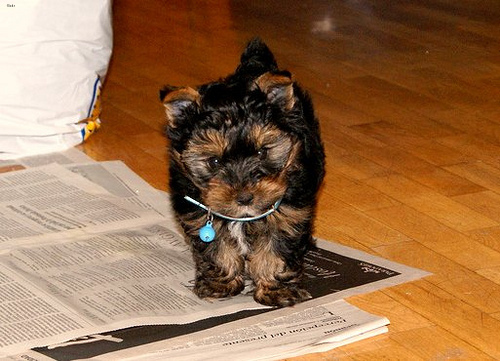

In [8]:
open_image(os.path.join(DATA_DIR, files[4]))

In [9]:
import os
from torch.utils.data import Dataset

class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
    self.classes = list(set(parse_breed(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [10]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size),
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size),
                                           T.ToTensor(),
                                           T.Normalize(*imagenet_stats)]))

In [11]:
len(dataset.classes)


37

In [12]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
  if len(images.shape) == 3:
    images = images.unsqueeze(0)
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_image(img_tensor, label):
  print('Label: ', dataset.classes[label], '(' + str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
  plt.imshow(img_tensor)

Label:  Sphynx (7)


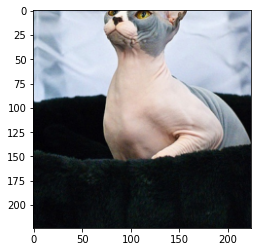

In [13]:
show_image(*dataset[10])

In [14]:
from torch.utils.data import random_split

In [15]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [16]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [17]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([]), ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

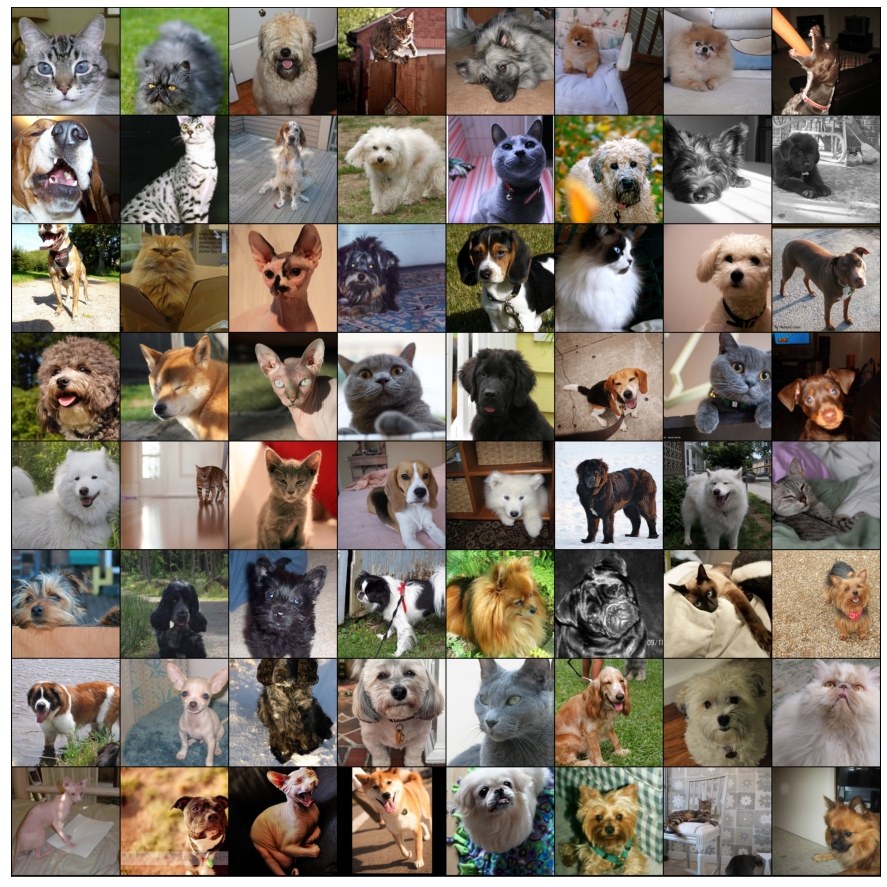

In [19]:
show_batch(train_dl)

In [53]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}/{}], Train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch,  "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [54]:
from torchvision import models

class PetsModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    self.network = models.resnet34(pretrained=pretrained)
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
    return self.network(xb)

In [55]:
models.resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [64]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    hisotry.append(result)
  return history

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cylce(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [65]:
device = get_default_device()
device

device(type='cuda')

In [66]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [67]:
model = PetsModel(len(dataset.classes))
to_device(model, device)

PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [68]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.04326128959655762, 'val_loss': 3.874199628829956}]

In [69]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [70]:
%%time
history += fit_one_cylce(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0/last_lr: 0.00589,], Train_loss: 1.3738, val_loss: 34.3167, val_acc: 0.0372


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/last_lr: 0.00994,], Train_loss: 1.9315, val_loss: 3.4561, val_acc: 0.1369


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/last_lr: 0.00812,], Train_loss: 1.3482, val_loss: 2.3164, val_acc: 0.3864


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/last_lr: 0.00463,], Train_loss: 0.8379, val_loss: 1.2714, val_acc: 0.6255


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/last_lr: 0.00133,], Train_loss: 0.4954, val_loss: 1.1276, val_acc: 0.6480


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/last_lr: 0.00000,], Train_loss: 0.3169, val_loss: 0.6324, val_acc: 0.7846
CPU times: user 2min 18s, sys: 2min 5s, total: 4min 23s
Wall time: 7min 59s


In [72]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [73]:
history2 = [evaluate(model2, valid_dl)]
history2

[{'val_acc': 0.029090378433465958, 'val_loss': 52.52876663208008}]

In [74]:
%%time
history2 += fit_one_cylce(epochs, max_lr, model2, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0/last_lr: 0.00589,], Train_loss: 3.5859, val_loss: 2571.3853, val_acc: 0.0357


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/last_lr: 0.00994,], Train_loss: 3.3792, val_loss: 34.0624, val_acc: 0.0513


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/last_lr: 0.00812,], Train_loss: 3.1885, val_loss: 3.3085, val_acc: 0.1207


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/last_lr: 0.00463,], Train_loss: 2.9595, val_loss: 3.1443, val_acc: 0.1420


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/last_lr: 0.00133,], Train_loss: 2.7104, val_loss: 2.9328, val_acc: 0.2000


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/last_lr: 0.00000,], Train_loss: 2.5224, val_loss: 2.6620, val_acc: 0.2598
CPU times: user 2min 19s, sys: 2min 5s, total: 4min 25s
Wall time: 8min 2s
